# Estimate distance between chair and Aria Glasses

In [1]:
import os
import cv2
import torch
import torchvision.transforms as transforms
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import timm
import segmentation_models_pytorch as smp
from torchvision.transforms import ToTensor
from PIL import Image, ImageDraw
from mmdet.apis import async_inference_detector, inference_detector
from mmdet.apis.inference import init_detector

from utils import *
from segment_anything import sam_model_registry, SamPredictor

/home/eyecode-binh/anaconda3/envs/depthestimation/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load models

In [2]:
person_mmdet_config_file = "/home/eyecode-binh/Estimating_distance_with_OpenMMLab_and_MiDaS/checkpoint_distance/yolov8_x_mask-refine_syncbn_fast_8xb16-500e_coco.py"
person_mmdet_checkpoint = '/home/eyecode-binh/Estimating_distance_with_OpenMMLab_and_MiDaS/checkpoint_distance/yolov8_x_mask-refine_syncbn_fast_8xb16-500e_coco_20230217_120411-079ca8d1.pth'
person_mmdet_model = init_detector(person_mmdet_config_file, person_mmdet_checkpoint, device='cuda:1')

Loads checkpoint by local backend from path: /home/eyecode-binh/Estimating_distance_with_OpenMMLab_and_MiDaS/checkpoint_distance/yolov8_x_mask-refine_syncbn_fast_8xb16-500e_coco_20230217_120411-079ca8d1.pth


# Load Aria Glasses video

In [3]:
path_video = '/home/eyecode-binh/Estimating_distance_with_OpenMMLab_and_MiDaS/video_demo/AriaEverydayActivities.mp4'

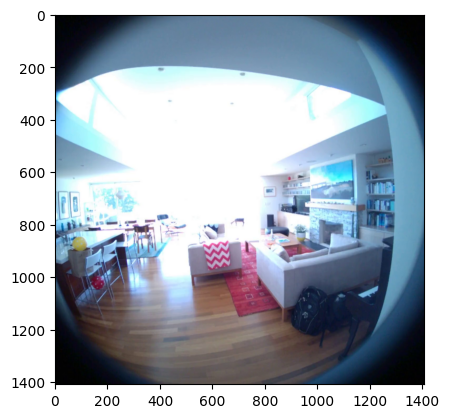

(1408, 1408, 3)

In [4]:
# visualize single frame
cap = cv2.VideoCapture(path_video)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()
plt.imshow(frame)
plt.show()

#print out the frame shape
frame.shape

In [5]:
def filter_class(raw_worker_bboxes, raw_worker_labels, raw_worker_scores, class_names, prefix='car'):
    worker_bboxes = []
    worker_labels = []
    worker_scores = []
    for i, worker_bbox in enumerate(raw_worker_bboxes):
        if raw_worker_labels[i] in class_names:
            worker_bboxes.append(worker_bbox)
            worker_labels.append(prefix)
            worker_scores.append(raw_worker_scores[i])
    return worker_bboxes, worker_labels, worker_scores

In [6]:
worker_threshold = 0.5
worker_results = inference_detector(person_mmdet_model, frame)
raw_worker_bboxes, raw_worker_labels, raw_worker_scores = mmdet3x_convert_to_bboxes_mmdet(worker_results, worker_threshold)
worker_bboxes, worker_labels, worker_scores = filter_class(raw_worker_bboxes, raw_worker_labels, raw_worker_scores, 'class_57', prefix='chair')

/home/eyecode-binh/anaconda3/envs/depthestimation/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


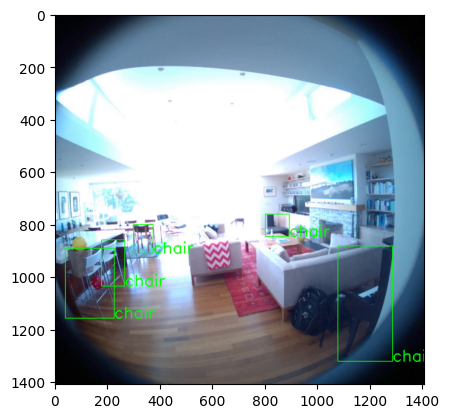

In [7]:
vis_results = mmdet3x_visualize_mmdet(frame, worker_bboxes, worker_labels)
plt.imshow(vis_results)
plt.show()

## Depth map estimation

In [8]:
from dpt.models import DPTDepthModel
from dpt.midas_net import MidasNet_large
from dpt.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

In [ ]:
def depth_estimation_dp(img):
    model_path = "/home/eyecode-binh/Estimating_distance_with_OpenMMLab_and_MiDaS/checkpoint_dpt/dpt_hybrid_384.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net_w = 1408
    net_h = 1408

    model = DPTDepthModel(
        path=model_path,
        scale=0.000305,
        shift=0.1378,
        invert=True,
        backbone="vitb_rn50_384",
        non_negative=True,
        enable_attention_hooks=False,
    )

    normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    transform = Compose(
            [
                Resize(
                    net_w,
                    net_h,
                    resize_target=None,
                    keep_aspect_ratio=True,
                    ensure_multiple_of=32,
                    resize_method="minimal",
                    image_interpolation_method=cv2.INTER_CUBIC,
                ),
                normalization,
                PrepareForNet(),
            ]
        )

    model.eval()
    model = model.to(memory_format=torch.channels_last)
    model = model.half()
    model.to(device)

    img_input = transform({"image": img})["image"]
    # computedpt_frame =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
    with torch.no_grad():
        sample = torch.from_numpy(img_input).to(device).unsqueeze(0)

        sample = sample.to(memory_format=torch.channels_last)
        sample = sample.half()

        prediction = model.forward(sample)
        prediction = (
            torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False,
            )
            .squeeze()
            .cpu()
            .numpy()
        )
    prediction *= 100.0
    return prediction

/home/eyecode-binh/anaconda3/envs/depthestimation/lib/python3.8/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
/home/eyecode-binh/anaconda3/envs/depthestimation/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


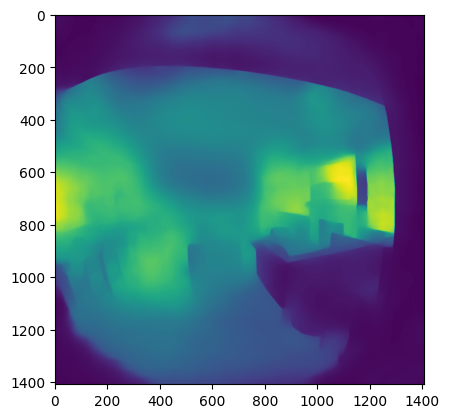

In [10]:
dpt_frame =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
depth_map = depth_estimation_dp(dpt_frame)
plt.imshow(depth_map)
plt.show()

# Combine and visualize

Object 0: chair
Coordinates: [39, 891, 225, 1157]
Object 1: chair
Coordinates: [1076, 882, 1284, 1321]
Object 2: chair
Coordinates: [177, 859, 265, 1035]
Object 3: chair
Coordinates: [800, 761, 891, 846]
Object 4: chair
Coordinates: [298, 801, 373, 910]


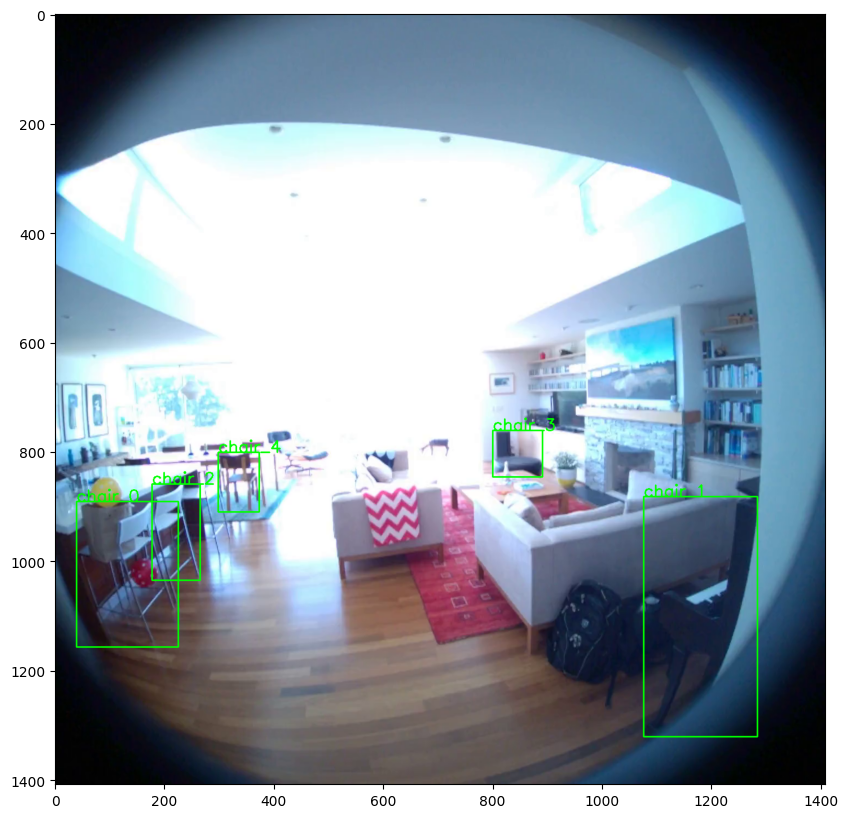

In [11]:
# combined and visualize
combined_bboxes = worker_bboxes
combined_labels = worker_labels
# vis_results = mmdet3x_visualize_mmdet(frame, combined_bboxes, combined_labels)
plt.figure(figsize=(10,10))
vis_results = frame.copy()
object_num = 0
for box, label in zip(combined_bboxes, combined_labels):
    # if object_num == 0 or object_num == 3 or object_num ==4:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(vis_results, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(vis_results, "{}_{}".format(label,object_num),
                                          (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    print("Object {}: {}".format(object_num, label))
    print("Coordinates: {}".format(box))
    object_num +=1
plt.imshow(vis_results)
plt.show()

{'x1': 39, 'y1': 891, 'x2': 225, 'y2': 1157, 'class': 'chair', 'depth': 343.2}
{'x1': 1076, 'y1': 882, 'x2': 1284, 'y2': 1321, 'class': 'chair', 'depth': 151.6}
{'x1': 177, 'y1': 859, 'x2': 265, 'y2': 1035, 'class': 'chair', 'depth': 387.5}
{'x1': 800, 'y1': 761, 'x2': 891, 'y2': 846, 'class': 'chair', 'depth': 428.2}
{'x1': 298, 'y1': 801, 'x2': 373, 'y2': 910, 'class': 'chair', 'depth': 454.2}


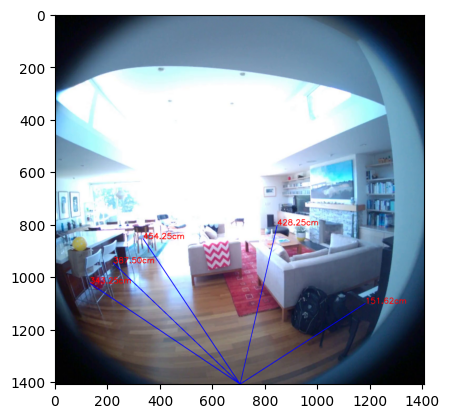

In [12]:
def extract_depth_from_boxes(boxes, depth_map):
    object_depths = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        object_depth_map = depth_map[y1:y2, x1:x2]
        median_depth = np.mean(object_depth_map)
        object_depths.append(median_depth)
    return object_depths

def extract_bounding_boxes_and_depth(detected_boxes, detected_labels, depths):
    objects = []
    for i, box in enumerate(detected_boxes):
        x1, y1, x2, y2 = map(int, box)
        obj = {
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'class': detected_labels[i],
            'depth': depths[i]
        }
        objects.append(obj)
    return objects

def find_center_coordinates_with_depth(box):
    x1, y1, x2, y2, depth = box
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    return center_x, center_y, depth

def compute_chair_to_camera_distance(objects):
    chair_distances = {}
    for i, obj in enumerate(objects):
        if obj['class'] == 'chair':
            chair_distances[i] = {'distance_to_camera': obj['depth']}
    return chair_distances

object_depths = extract_depth_from_boxes(combined_bboxes, depth_map)
object_infor = extract_bounding_boxes_and_depth(combined_bboxes, combined_labels, object_depths)
#hiển thị thông tin object và depth
for obj in object_infor:
    print(obj)
object_distances = compute_chair_to_camera_distance(object_infor)
center_points = [((box['x1'] + box['x2']) // 2, (box['y1'] + box['y2']) // 2)
                 for box in object_infor]

violated_worker = 0
for i, distance_info in object_distances.items():
    pt1 = center_points[i]
    distance = distance_info['distance_to_camera']

    # Hiển thị khoảng cách lên hình ảnh
    cv2.putText(frame, f"{distance:.2f}cm", pt1, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Hiển thị line từ camera đến object
    cv2.line(frame, (frame.shape[1]//2, frame.shape[0]), pt1, (0, 0, 255), 2)
    if distance < 100:
        violated_worker += 1

plt.imshow(frame)
plt.show()